# Exercise 8 - Grupo 5

The result will be evaluated from a report in Jupyter, which must be found in a public GitHub repository. The project must be carried out in the groups assigned in class. Use clear and rigorous procedures. Due date: July 18, 2021, 11:59 pm, through Bloque Neón + (Upload repository link)

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline

import pandas            as pd 
import numpy             as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn                 import metrics
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from matplotlib.pyplot       import figure
from xgboost                 import XGBClassifier

plt.style.use('classic')

In [2]:
data = pd.read_csv('../datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [3]:
data.shape

(13150, 10)

In [4]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the decision trees notebook.

## Definición de funciones necesarias

In [6]:
#Función para cálculo de Gini
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

#Función para cálculo de Gini gain
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]    
    y_r = y.loc[~filter_l]   
    n_l = y_l.shape[0] 
    n_r = y_r.shape[0] 
    gini_y = gini(y)   
    gini_l = gini(y_l) 
    gini_r = gini(y_r) 
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r) 
    return gini_impurity_

#Función para elegir variable y punto de corte
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 0]
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist()) 
        splits = np.unique(splits)[1:]
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
            if gain > best_split[2]: 
                best_split = [j, split, gain]
    return best_split

#Función para entrenar árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    j, split, gain = best_split(X, y, num_pct)
    y_pred = int(y.mean() >= 0.5)
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain) 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l] 
    tree['split'] = [j, split]
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct) 
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

#Función para predecir sobre árbol entrenado
def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])
    if tree['split'] == -1: 
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    return predicted   

Se entrena el árbol sobre el set de training y los parámetros por defecto.

In [7]:
tree = tree_grow(X_train, y_train)

Evaluate the accuracy on the testing set

In [8]:
pred_tree = tree_predict(X_test, tree)
metrics.accuracy_score(pred_tree, y_test)

0.8433179723502304

Con el árbol entrenado se tiene el 84.33% de las observaciones clasificadas correctamente.

# Exercise 8.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in bagging notebook.

In [9]:
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
treeClf = DecisionTreeClassifier(max_depth=None, random_state=123)
pred_bag10 = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])
for i, sample in enumerate(samples):
    X_train_ = X_train.iloc[sample,:]
    y_train_ = y_train.iloc[sample, ]
    treeClf.fit(X_train_, y_train_)
    pred_bag10[i] = treeClf.predict(X_test)

Evaluate the accuracy on the testing set


In [10]:
pred_bag10=(pred_bag10.sum(axis=1) >= n_B / 2).astype(np.int32)
metrics.accuracy_score(pred_bag10, y_test)

0.8476958525345623

Con el modelo de bagging de 10 árboles se obtiene el 84.79% de las observaciones clasificadas correctamente.
# Exercise 8.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.
<br>Compare the impact in the results by varing the parameter max_features
<br>Evaluate the accuracy on the testing set
<br><br>Entrenamos el árbol incorporando el parametro 'max_depth' con valores de 1 a 20.

In [11]:
max_depth_range = range(1, 21)
accuracy_scores = []
for depth in max_depth_range:
    tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=depth, num_pct=10)
    pred_tree_depth = tree_predict(X_test, tree)
    accuracy_scores.append(metrics.accuracy_score(pred_tree_depth, y_test))

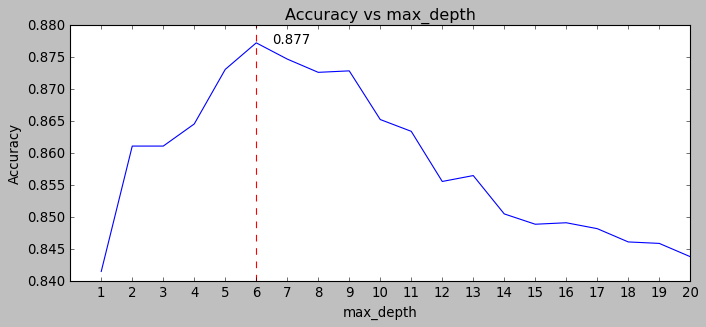

In [12]:
best_depth=sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1]
best_acc=sorted(zip(accuracy_scores, max_depth_range))[::-1][0][0]

figure(figsize=(10, 4))
plt.plot(max_depth_range, accuracy_scores, linewidth=1)
plt.axvline(best_depth, color ="red", linestyle="dashed")
plt.xlabel('max_depth')
plt.xticks(ticks=range(1, 21))
plt.ylabel('Accuracy')
plt.annotate(np.int32(1000*best_acc)/1000, (best_depth+0.5,best_acc))
plt.title('Accuracy vs max_depth');

Al variar el parámetro 'max_depth' se encuentra que alcanza el mejor accuracy en el valor 6 clasificando correctamente el 87.7% de las observaciones.
# Exercise 8.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Esta opción se ingresa con el argumento 'max_features'="log2" en la función 'DecisionTreeRegressor'.

In [13]:
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
treeClf = DecisionTreeClassifier(max_depth=None, random_state=123,max_features="log2")
pred_bag_feat_log = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])
for i, sample in enumerate(samples):
    X_train_ = X_train.iloc[sample,:]
    y_train_ = y_train.iloc[sample, ]
    treeClf.fit(X_train_, y_train_)
    pred_bag_feat_log[i] = treeClf.predict(X_test)
pred_bag_feat_log=(pred_bag_feat_log.sum(axis=1) >= n_B / 2).astype(np.int32)

Evaluate the accuracy on the testing set

In [14]:
metrics.accuracy_score(pred_bag_feat_log, y_test)

0.8423963133640553

Al incluir el argumento 'max_features'="log2" se obtiene el 84.23% de las observaciones clasificadas correctamente.
# Exercise 8.5
Using sklearn, train a RandomForestClassifier

In [15]:
RFclf = RandomForestClassifier()
RFclf.fit(X_train,y_train);

Evaluate the accuracy on the testing set

In [16]:
pred_rf=RFclf.predict(X_test)
metrics.accuracy_score(pred_rf, y_test)

0.8377880184331797

Con el modelo de random forest se tiene el 83.8% de las observaciones clasificadas correctamente.
# Exercise 8.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators) and evaluate the accuracy on the testing set.
<br>Para seleccionar cada parámetro se iterará sobre un rango de valores posibles manteniendo los demás en su valor default.
## 'max_depth'

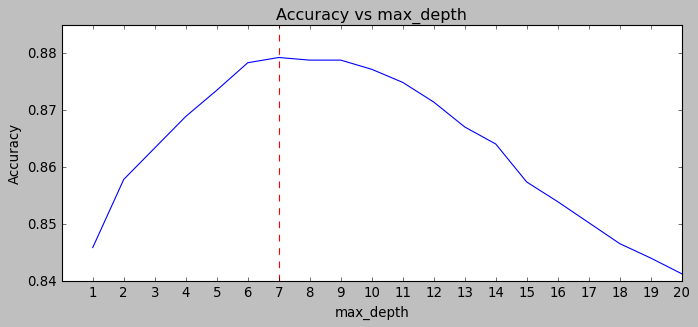

In [17]:
#max_depth
depth_range = range(1, 21)
accuracy_scores_depth = []
for depth in depth_range:
    rfclf_ = RandomForestClassifier(max_depth=depth,random_state=1, n_jobs=-1)
    rfclf_.fit(X_train,y_train)
    pred_rf_depth=rfclf_.predict(X_test)
    accuracy_scores_depth.append(metrics.accuracy_score(pred_rf_depth, y_test))
best_depth=sorted(zip(accuracy_scores_depth, depth_range))[::-1][0][1]
figure(figsize=(10, 4))
plt.plot(depth_range, accuracy_scores_depth, linewidth=1)
plt.axvline(best_depth, color ="red", linestyle="dashed")
plt.xlabel('max_depth')
plt.xticks(ticks=depth_range)
plt.ylabel('Accuracy')
plt.ylim(0.84,0.885)
plt.title('Accuracy vs max_depth');

Manteniendo los demás parámetros en su valor default, el valor de 'max_depth' que maximiza el accuracy para el modelo es 7.
## 'max_features'

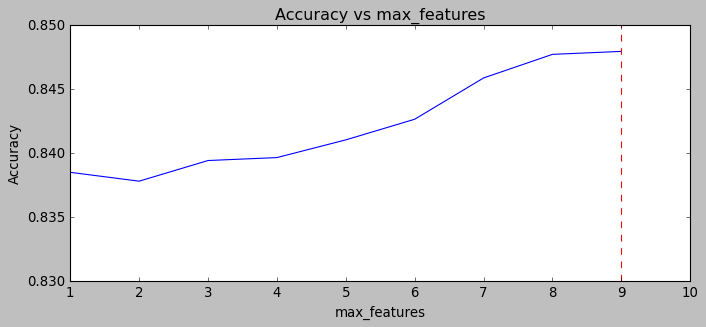

In [18]:
#max_features
feature_range = range(1,1+len(X_train.columns))
accuracy_scores_features = []
for feature in feature_range:
    rfclf_ = RandomForestClassifier(max_features=feature, random_state=1, n_jobs=-1)
    rfclf_.fit(X_train,y_train)
    pred_rf_feat=rfclf_.predict(X_test)
    accuracy_scores_features.append(metrics.accuracy_score(pred_rf_feat, y_test))
best_features=sorted(zip(accuracy_scores_features, feature_range))[::-1][0][1]
figure(figsize=(10, 4))
plt.plot(feature_range, accuracy_scores_features, linewidth=1)
plt.axvline(best_features, color ="red", linestyle="dashed")
plt.xlabel('max_features')
plt.xticks(ticks=range(1,11))
plt.ylabel('Accuracy')
plt.ylim(0.83,0.85)
plt.title('Accuracy vs max_features');

Manteniendo los demás parámetros en su valor default, el valor de 'max_features' que maximiza el accuracy para el modelo es 9, la mejor opción es la que tiene disponibles todas las variables predictoras, sin embargo la diferencia no es muy amplia.
## 'n_estimators'

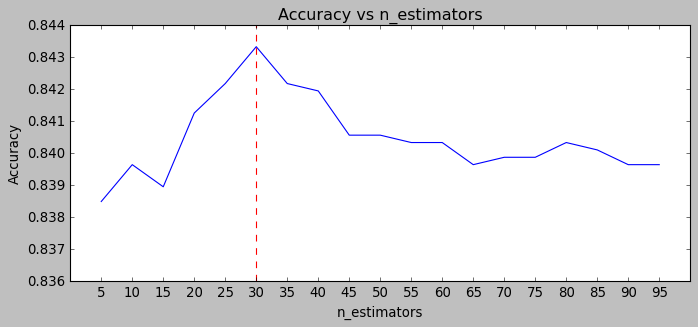

In [19]:
#estimators
estimators_range = range(5, 100,5)
accuracy_scores_estimators = []
for estimator in estimators_range:
    rfclf_ = RandomForestClassifier(n_estimators=estimator,  random_state=1, n_jobs=-1)
    rfclf_.fit(X_train,y_train)
    pred_rf_estimators=rfclf_.predict(X_test)
    accuracy_scores_estimators.append(metrics.accuracy_score(pred_rf_estimators, y_test))
best_estimators=sorted(zip(accuracy_scores_estimators, estimators_range))[::-1][0][1]
figure(figsize=(10, 4))
plt.plot(estimators_range, accuracy_scores_estimators, linewidth=1)
plt.axvline(best_estimators, color ="red", linestyle="dashed")
plt.xlabel('n_estimators')
plt.xticks(ticks=estimators_range)
plt.ylabel('Accuracy')
plt.ylim(0.836,0.844)
plt.title('Accuracy vs n_estimators');

Manteniendo los demás parámetros en su valor default, el valor de 'n_estimators' que maximiza el accuracy para el modelo es 30.
<br>Con el modelo de random forest parametrizado con los valores hallados se tiene el 87.78% de las observaciones clasificadas correctamente.

In [20]:
rfclf_ = RandomForestClassifier(n_estimators=30,max_depth=7,max_features=9,random_state=1, n_jobs=-1)
rfclf_.fit(X_train,y_train)
pred_rf_ttl=rfclf_.predict(X_test)
metrics.accuracy_score(pred_rf_ttl, y_test)

0.8776497695852534

# Exercise 8.7 

Using xgboost train a XGBClassifier and evaluate the accuracy on the testing set

In [21]:
XGBclf = XGBClassifier()
XGBclf.fit(X_train,y_train)
pred_XGB=XGBclf.predict(X_test)
metrics.accuracy_score(pred_XGB, y_test)

[20:34:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8790322580645161

Con el modelo de xgboost se tiene el 87.9% de las observaciones clasificadas correctamente.
# Exercise 8.8

Using xgboost train a XGBClassifier 

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

In [22]:
XGBclf = XGBClassifier(eta=0.2,gamma=0.001,colsample_bytree=0.9)
XGBclf.fit(X_train,y_train)
pred_XGB=XGBclf.predict(X_test)

[20:34:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


El parámetro **learning rate** o 'eta' controla el grado de mejora de un árbol respecto al anterior; un learning rate pequeño implica una mejora más lenta, pero se adapta mejor a los datos y generalmente consigue mejores resultados a costa de un mayor consumo de recursos.
<br>El parámetro **gamma** es un parámetro de regularización, su función es evitar el sobreajuste.
<br>El parámetro **colsample_bytree** controla la cantidad de variables que estarán disponibles al construir los árboles, sigue el mismo principio de 'max_features' en el algoritmo 'DecisionTreeClassifier' con la diferencia de que en 'XGBClassifier' se expresa como porcentaje.

Evaluate the accuracy on the testing set

In [23]:
metrics.accuracy_score(pred_XGB, y_test)

0.8804147465437788

En el modelo de xgboost donde se modificaron los parámetros mencionados se tiene el 88.04% de las observaciones clasificadas correctamente.
<br><br>Se observa que de todos los modelos ejecutados el ranking de desempeño estaría liderado por XGBoost seguido por Random forest, sin embargo la diferencia no es muy alta.